In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

# from warpctc_pytorch import CTCLoss

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [4]:
!ls {PATH}

20_words.csv	 lines	      synth_words.csv	 words
ascii		 lines.tgz    tmp		 words_chars.csv
chars.csv	 models       word_char_ids.csv  words.csv
line_labels.csv  synth_words  word_labels.csv	 words.tgz


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Synthetic Data

### images

In [6]:
os.makedirs(PATH/'synth_words', exist_ok=True)

In [7]:
def create_img(files, fname):
    imgs    = [ PIL.Image.open(PATH/'words'/f) for f in files ]
    widths, heights = zip(*(i.size for i in imgs))

    total_height = sum(heights)
    max_width = max(widths)

    new_im = Image.new('RGB', (max_width, total_height), color=(255,255,255))

    y_offset = 0
    for im in imgs:
      new_im.paste(im, (0,y_offset))
      y_offset += im.size[1]

    new_im.save(PATH/'synth_words'/fname)

### labels

In [8]:
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    char_len = len(gtText)
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText, char_len])
    
data = np.stack(samples)
df = pd.DataFrame(data, columns=['filename', 'word', 'char_len'], )
df.head()

,filename,word,char_len
0,a01-000u-00-00,A,1
1,a01-000u-00-01,MOVE,4
2,a01-000u-00-02,to,2
3,a01-000u-00-03,stop,4
4,a01-000u-00-04,Mr.,3


### Create Data

In [9]:
df['char_len'] = df.char_len.astype('int32')
gt3 = df.loc[df['char_len'] > 3]

In [10]:
def create_synth_data(num):
    d={}
    for i in range(num):
        res = gt3.sample(3)
        files = list(map(lambda x: x+'.png', res.filename.values))
        label = ' '.join(res.word.values)

        fname = '{:03d}'.format(i)+'.png'
        create_img(files, fname)
        d[fname] = label
    return d

d = create_synth_data(10000)
len(d)

10000

In [11]:
synth = pd.DataFrame({'filename': list(d.keys()), 'labels': list(d.values())})
synth.tail()

,filename,labels
9995,9995.png,life leaders nimble-fingered
9996,9996.png,prior aged arose
9997,9997.png,home purveying voice
9998,9998.png,Berlin paper here
9999,9999.png,business friends than


# Prelim

### Numericalize characters

In [12]:
itos = sorted(list(chars))
itos.insert(0, '_pad_')
itos.insert(1, ' ')
itos.insert(2, '_unk_')
len(itos)

81

In [13]:
joined_labels = list(d.values()) #list(map(lambda x: ' '.join(x), labels))

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word]) for word in joined_labels])

In [14]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [15]:
synth['char_ids'] = str_ids
synth.head()

,filename,labels,char_ids
0,000.png,most people disc,67 69 73 74 1 70 59 69 70 66 59 1 58 63 73 57
1,001.png,them occurs dried,74 62 59 67 1 69 57 57 75 72 73 1 58 72 63 59 58
2,002.png,delight reasonably could,58 59 66 63 61 62 74 1 72 59 55 73 69 68 55 56...
3,003.png,they after ready,74 62 59 79 1 55 60 74 59 72 1 72 59 55 58 79
4,004.png,chosen alarmed authority,57 62 69 73 59 68 1 55 66 55 72 67 59 58 1 55 ...


In [16]:
# length of longest string -> seq_len
synth.char_ids.map(lambda x: len(x.split(' '))).max()

39

In [17]:
np.save(TMP_PATH/'synth_word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'synth_word_itos.pkl', 'wb'))

### Save to CSV

In [6]:
# ids = np.load(TMP_PATH/'synth_word_ids.npy')
itos = pickle.load(open(TMP_PATH/'synth_word_itos.pkl', 'rb'))

#### full dataset

In [7]:
CSV = PATH/'synth_words.csv'

# synth.to_csv(CSV, columns=['filename', 'char_ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,000.png,67 69 73 74 1 70 59 69 70 66 59 1 58 63 73 57
1,001.png,74 62 59 67 1 69 57 57 75 72 73 1 58 72 63 59 58
2,002.png,58 59 66 63 61 62 74 1 72 59 55 73 69 68 55 56...
3,003.png,74 62 59 79 1 55 60 74 59 72 1 72 59 55 58 79
4,004.png,57 62 69 73 59 68 1 55 66 55 72 67 59 58 1 55 ...


#### sample (1000)

In [6]:
CSV = PATH/'synth_words_1000.csv'

# csv = csv.sample(1000)
# csv.reset_index(drop=True, inplace=True)
# csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

csv = pd.read_csv(CSV)
len(csv)

1000

### Get val_idxs

In [8]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

1500

### Preprocess (rotate, normalize)

In [9]:
f = resnet34
sz = 128
bs = 30

In [10]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'synth_words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [11]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### View image transforms

In [11]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

In [12]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [29]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)

    #ax.set_axis_off()
    ax.set_yticks([16, 48, 80, 112], minor=True)
    ax.set_xticks([16, 48, 80, 112], minor=True)
    ax.set_yticks([32, 64, 96, 128], minor=False)
    ax.set_xticks([32, 64, 96, 128], minor=False)
    ax.yaxis.grid(True, which='both')
    ax.xaxis.grid(True, which='both')

    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


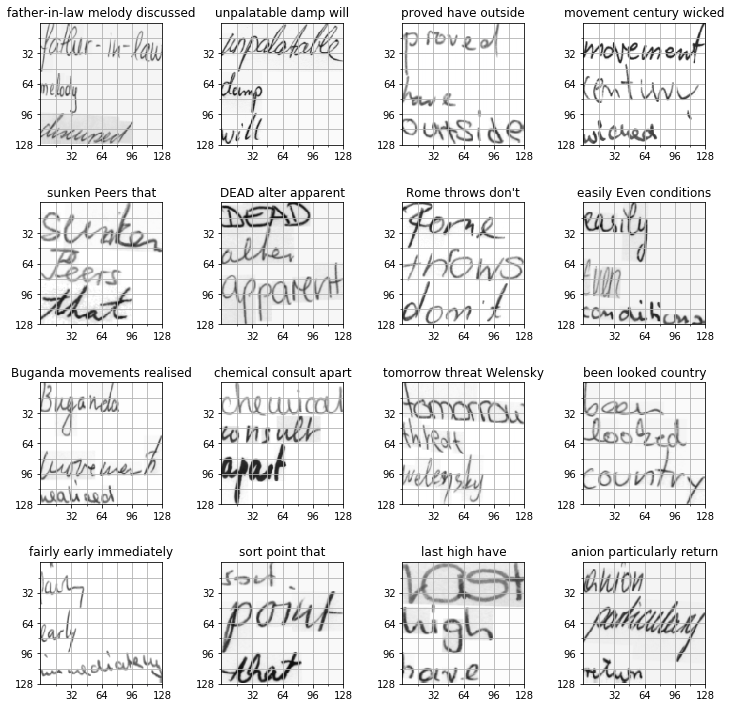

In [30]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss fns

In [12]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [14]:
ctc_loss = CTCLoss()
# ctc_loss = nn.CTCLoss()  #pytorch master branch (unreleased)

def custom_loss(input, target):
    bs,sl = target.size()      #=> ([bs, sl])
    _,sl_in,vs = input.size()  #=> ([bs, 4, 16, 80])
    inp = input.permute(1,0,2) #=> ([sl_in, bs, 80])
    
    inp_lens = torch.full((bs,), sl_in, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[i,:]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
    
#     targ = target.reshape(bs*sl).type(torch.int32)
#     targ_lens = torch.full((bs,), sl, device=device, dtype=torch.int32)
    
    return ctc_loss(inp, targ, inp_lens, targ_lens)    
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

# Hybrid Arch

### Blocks

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.2, p=(2,2)):
        super().__init__()
        self.p = p
        
        self.drop = nn.Dropout(drop)
        self.conv = nn.Conv2d(ni*p[0]*p[1], nh, 3, padding=1)  #maintain size
        self.bn   = nn.BatchNorm2d(nh)
    
    def tile(self, x):
        bs, nf, h, w = x.size()   # Note: different order than ReNet tile!!!
        p_height = self.p[0]
        p_width  = self.p[1]

        assert h % p_height == 0
        assert w % p_width  == 0

        new_height = int(h / p_height)
        new_width  = int(w / p_width)

        x = x.view(bs, nf, new_height, p_height, new_width, p_width)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(bs, nf * p_height * p_width, new_height, new_width)
        return x

    def forward(self, x):
        x = self.tile(x)
        x = self.bn(self.conv(self.drop(x)))
        x = F.leaky_relu(x)
        return x

In [12]:
class ReNetBlock(nn.Module):
    def __init__(self, ni, nh, drop=0.4, p=(2,2)):
        super(ReNetBlock, self).__init__()
        
        self.p_height = p[0]
        self.p_width = p[1]

        self.drop = nn.Dropout(drop)
        self.vrnn = nn.GRU(ni*self.p_height*self.p_width, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
        self.hrnn = nn.GRU(2*nh, nh, num_layers=1,
                           bias=True, batch_first=True, bidirectional=True)
    
    def tile(self, x):
        bs, h, w, nf = x.size()

        assert h % self.p_height == 0
        assert w % self.p_width  == 0

        new_height = int(h / self.p_height)
        new_width  = int(w / self.p_width)

        x = x.view(bs, new_height, self.p_height, new_width, self.p_width, nf)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        x = x.view(bs, new_height, new_width, self.p_height * self.p_width * nf)
        return x
    
    def rnn_forward(self, x, hor_or_ver):
        assert hor_or_ver in ['hor', 'ver']
        bs, h, w, nf = x.size()

        x = x.view(bs*h, w, nf)
        if hor_or_ver == 'hor':
            x, _ = self.hrnn(x)
        else:
            x, _ = self.vrnn(x)
        x = x.contiguous()
        x = x.view(bs, h, w, -1)
        return x

    def forward(self, inp):
        x = self.tile(inp)                 #bs, h, w, nf
        x = self.drop(x)
        
        x = self.rnn_forward(x, 'ver')
        x = x.permute(0, 2, 1, 3)          #bs, w, h, nf
        x = x.contiguous()
        
        x = self.rnn_forward(x, 'hor')
        x = x.permute(0, 2, 1, 3)          #bs, h, w, nf
        x = x.contiguous()
        return x

### Original

In [ ]:
class Hybrid(nn.Module):
    def __init__(self, nh, vs):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
           
        self.block1 = ReNetBlock(16, nh, p=(4,2))
        self.block2 = ReNetBlock(32, nh, p=(2,2))
        self.block3 = ReNetBlock(64, nh, p=(2,2))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(2,1))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,1))
        self.conv3 = ConvBlock(nh*2, 128, p=(2,1))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(0, 2, 3, 1)
        x = self.drop(x)
        x = self.out(x)      #([30, 1, 16, 80])
        
        return x.squeeze(1)

In [ ]:
net = Hybrid(100, len(itos))
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.crit = custom_loss
learn.clip = 10.
learn.metrics = [char_error_rate]

### Customized

In [71]:
class Encoder(nn.Module):
    def __init__(self, vs):
        super().__init__()
        nh = 100
        
        self.conv0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
           
        self.block1 = ReNetBlock(16, nh, p=(2,2))
        self.block2 = ReNetBlock(32, nh, p=(2,2))
        self.block3 = ReNetBlock(64, nh, p=(1,1))
        
        self.conv1 = ConvBlock(nh*2, 32, p=(2,2))
        self.conv2 = ConvBlock(nh*2, 64, p=(2,2))
        self.conv3 = ConvBlock(nh*2, 128, p=(1,1))
        
        self.drop = nn.Dropout(0.4)
#         self.out = nn.GRU(128, vs, 1)
        self.out = nn.Linear(128, vs)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        
        x = self.conv0(inp)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv1(x)
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2(x)

        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block3(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv3(x)

        x = x.permute(2, 3, 0, 1).flatten(0,1) #h*w,bs,nf
        x = self.drop(x)
        
        x = self.out(x)      #([bs, 1, 16, 80])
        
        return x

# Transpose/concat bidir encoder; attention decoder

In [24]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        self.hrnn = nn.GRU(embed_size, embed_size//2, 1, bidirectional=True)
        self.vrnn = nn.GRU(embed_size, embed_size//2, 1, bidirectional=True)
        self.rnn  = nn.GRU(embed_size*2, embed_size, 1)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()    #head => 8x8x256
        hor = torch.flatten(inp, 2,3)  
        outh,hh = self.hrnn(hor.permute(2, 0, 1))   #([64,30,256])
        
        # transpose input
        ver = torch.transpose(inp, 2,3).flatten(2,3)
        outv,hv = self.vrnn(ver.permute(2, 0, 1))
        # un-transpose rnn output
        outv = outv.reshape(w,h,bs,-1)
        outv = outv.transpose(1,0).flatten(0,1)
        # concat results
        out = torch.cat((outh, outv), -1)
        h = torch.cat((hh[-1], hv[-1]), -1)
                        
        return self.rnn(out, h.unsqueeze(0))

In [28]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.seq_len = seq_len
        
        head = Encoder(embed_size)
        self.encoder = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=head).model

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        
        # setting up Attention Layers
#         self.W1 = rand_p(embed_size, embed_size)
        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size) 
        self.attn_3 = nn.Linear(embed_size*2, embed_size)
        self.attn_v = rand_p(embed_size)

    def forward(self, inp, ret_attn=False):        
        ### Encoder ###
        bs = inp.size(0)        
        out, h = self.encoder(inp)
                        
        ### Decoder ###
        dec_inp = torch.zeros(bs, device=device).long()
        
        res,attns = [],[]
        #w1e = out @ self.W1  #=> ([16, 30, 256])          # encoder hidden states
        w1e = self.attn_1(out)
        
        for i in range(self.seq_len):
            w2h = self.attn_2(h)  #=> ([1, 30, 256])          # current decoder hidden state
            u = torch.tanh(w1e + w2h) #=> ([16, 30, 256])
            a = torch.softmax(u @ self.attn_v, 0)  #=> ([16, 30])    # attention mask
            attns.append(a)

            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * out).sum(0) #=> ([30, 256])

            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
                     
            # concatenated w/ current decoder hidden...  -> paper version
#             wgt_h = self.attn_3(torch.cat([Xa.unsqueeze(0),h], 2)) #=> ([1, 30, 256])
#             outp, h = self.dec_rnn(emb.unsqueeze(0), wgt_h)
            
            # concatenated w/ embeddings and fed as input...  -> jeremy's version
            wgt_enc = self.attn_3(torch.cat([emb, Xa], 1)) #=> ([30, 256])
            outp, h = self.dec_rnn(wgt_enc.unsqueeze(0), h)

            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = outp.data.max(1)[1]          # predictions => ([30])
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

## Vanilla decoder

In [61]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.seq_len = seq_len
        
        head = Encoder(embed_size)
        self.encoder = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=head).model

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)

    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)        
        out, h = self.encoder(inp)
                        
        ### Decoder ###
        dec_inp = torch.zeros(bs, device=device).long()
        
        res = []
        for i in range(self.seq_len):
            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
            outp, h = self.dec_rnn(emb.unsqueeze(0), h)

            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = outp.data.max(1)[1]          # predictions => ([30])
            
        res = torch.stack(res)
        return res

## LR find

 69%|██████▉   | 196/284 [00:32<00:14,  6.09it/s, loss=229] 

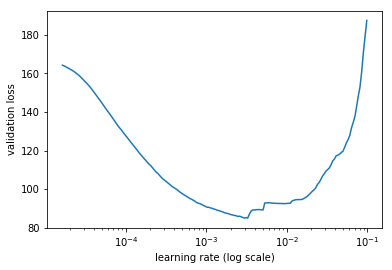

In [30]:
learn.lr_find()
learn.sched.plot()

## Train

In [64]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(256, len(itos), 1, 40)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

In [65]:
lr=1e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min
# "", "", renet/conv 4x4    70.269559  54.043423    2.5min    **
# "", "", renet/conv 8x8    84.064616  55.46244     3.1min

#em_sz:256, num_layers:1
#flatten->rnn_encoder,attn (input)   71.984349  55.902448     -> 75.9 (75.6 w/ grad clipping, 73.9, 73.5)
#                      alt (hidden)  80.700541  66.80391      -> matches paper...  90.4,88.99,86.2
# transposed/concatenated                                     -> 74.978793

# GPU
#10000, lr:1e-4
# trans/cat enc, attn       69.061411  67.957871              -> 61.525784  61.807825 (**11cycles)
# "", vanilla decoder       69.462132  68.390057

  0%|          | 0/284 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [35]:
learn.save('1cycle')

### Continue training

In [36]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,4))

epoch      trn_loss   val_loss                              
    0      68.073755  67.260952 
    1      66.726001  66.056838                             
    2      65.222971  65.651269                             
    3      64.853387  63.977445                             
    4      63.763634  63.656874                             


[63.656874389648436]

In [37]:
learn.save('6cycle')

In [49]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,4))

epoch      trn_loss   val_loss                              
    0      63.919463  65.78036  
    1      63.583184  63.95676                              
    2      62.884559  62.695055                             
    3      62.246516  62.243178                             
    4      61.525784  61.807825                             


[61.80782493591309]

In [50]:
learn.save('11cycle')

# Luong Attention
https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

In [35]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, x, hidden=None):
        x = x.flatten(2,3).permute(2,0,1)
        outputs, hidden = self.gru(x, hidden)

        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]

        return outputs, hidden

In [48]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [53]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.n_layers = n_layers
        
        # Define layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.attn = Attn('concat', hidden_size)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, vocab_size)


    def forward(self, x, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding_dropout(self.embedding(x))
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [115]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, dropout=0.1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        head = EncoderRNN(hidden_size)
        self.encoder = ConvnetBuilder(f, 0, 0, 1, xtra_cut=1, custom_head=head).model
        self.decoder = LuongAttnDecoderRNN(hidden_size, vocab_size)
        
    def forward(self, x):
        bs = x.size(0)
        enc_outs, enc_h = self.encoder(x)
        
        res = []
        dec_inp = torch.zeros(bs, device=device).long()
        dec_h = enc_h[:self.decoder.n_layers]
        for i in range(self.seq_len):
            dec_out, dec_h = self.decoder(dec_inp.unsqueeze(0), dec_h, enc_outs)            
            res.append(dec_out)
            dec_inp = V(dec_out.data.max(1)[1])          # predictions => ([30])
                
        return torch.stack(res)

In [107]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 40, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

In [112]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 1, lr:7e-4, em_sz: 256
# LuongAttnDecoderRNN                          157.49
#   w/ teacher forcing                         157.47

epoch      trn_loss   val_loss                           
    0      121.805012 157.478812


[157.47881164550782]

In [114]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,5))

epoch      trn_loss   val_loss                           
    0      121.3856   157.4729  
    1      121.224356 157.4729                           
 55%|█████▌    | 16/29 [01:13<01:00,  4.64s/it, loss=122]

KeyboardInterrupt: 

# Custom2

In [22]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
        # when the forward method of this module (m) is called it will call self.hook_fn
    def hook_fn(self, module, input, output): self.features = output
        # stores output in the features attribute
    def close(self): self.hook.remove()
        
        
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        self.base = ConvnetBuilder(f, embed_size, 0, 0, xtra_cut=1).model   #([30,256,8,8])
#         self.base = ConvnetBuilder(f, embed_size, 0, 0).model               #([30,512,4,4])
        self.grid = SaveFeatures(children(self.base)[-11])  

    def forward(self, inp):
        h = self.base(inp)
        
        feats = self.grid.features
        feats = torch.flatten(feats, 2,3)
        feats = feats.permute(2,0,1)
        
        return feats, h

In [10]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.encoder = Encoder(embed_size)

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        
        # setting up Attention Layers
        self.W1 = rand_p(embed_size, embed_size)
#         self.W1 = nn.Conv2d(embed_size, embed_size, 2)
        self.l2 = nn.Linear(embed_size, embed_size) 
        self.l3 = nn.Linear(embed_size+embed_size, embed_size)
        self.V  = rand_p(embed_size)

    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)        
        out, h = self.encoder(inp)         #([30, 4, 4, 256])
        #h = torch.stack((h,h))          #(2, 30, 256)   # 2 layers
                
        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())
        
        res,attns = [],[]
        
        
        w1e = out @ self.W1  #=> ([16, 30, 256])

        for i in range(self.seq_len):
            # take current hidden state of decoder and put it into a linear layer
            w2h = self.l2(h[-1])  #=> ([1, 30, 256])
            # non-linear activation
            u = torch.tanh(w1e + w2h) #=> ([16, 30, 256])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = torch.softmax(u @ self.V, 0)  #=> ([16, 30])
            attns.append(a)
            # a.unsqueeze(2): add axis at index 2 => ([16, 30, 1])
            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * out).sum(0) #=> ([30, 256])

            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
            
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([30, 256])
            outp, h = self.dec_rnn(wgt_enc.unsqueeze(0), h)
            
            

#         res = []
#         for i in range(self.seq_len):
#             emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
#             outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 30, 256]),  ([2, 30, 256])
            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])          # predictions => ([30])
        return torch.stack(res)

In [104]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(256, len(itos), 1, 35)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [105]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min
# "", "", renet/conv 4x4    70.269559  54.043423    2.5min    **
# "", "", renet/conv 8x8    84.064616  55.46244     3.1min

# ConvnetBuilder(f, embed_size, 0, 0)   77.697741  55.164891  t_____
# ConvnetBuilder(f, embed_size, 1, 1)   81.846109  59.502135  e_____
# ConvnetBuilder(f, embed_size, 0, 1)   93.810281  62.048532  ____ee

# "", attn

#10000, lr:7e-4              50.689892  49.319883    20min
# w/ STN before encoder      

epoch      trn_loss   val_loss                           
    0      101.764574 55.0019   


[55.00189971923828]

In [108]:
learn.fit(lr, 1, cycle_len=5, use_clr=(10,5))

epoch      trn_loss   val_loss                            
    0      55.233789  55.212958 
    1      55.222451  59.196336                           
    2      54.200469  53.966232                           
    3      53.484065  54.255312                           
    4      53.075202  53.56874                            


[53.56874008178711]

# Seq2seq (translation)

In [123]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        self.encoder = ConvnetBuilder(f, embed_size, True, True).model

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)
        #self.init_weights()

    def init_weights(self):
        self.dec_emb.weight.data.uniform_(-0.1, 0.1)
        self.dec_linear.weight.data = self.dec_emb.weight.data  #weight tying??
        self.dec_linear.bias.data.fill_(0)
        
    def forward(self, inp):        
        ### Encoder ###
        bs = inp.size(0)
        enc = self.encoder(inp)         #([30, 256])
        h = enc.unsqueeze(0) #torch.stack((enc,enc)) 

        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.seq_len):
            emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
            outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 30, 256]),  ([2, 30, 256])
            #1 layer:  outp == h
            #2 layers: outp == h[-1]
            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])  #=> ([125])
        return torch.stack(res)                       # ([35, 30, 81])

In [124]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(512, len(itos), 1, 35)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

In [125]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", num_layers: 1         84.144111  60.642912    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min

#10000, lr:7e-4              50.689892  49.319883    20min
# w/ STN before encoder      

epoch      trn_loss   val_loss                            
    0      84.144111  60.642912 


[60.64291229248047]

# Attention

In [66]:
class Encoder(nn.Module):
    def __init__(self, nh):
        super().__init__()
        
        #head => 8x8x256
        self.block1 = ReNetBlock(256, nh, p=(2,2))
        
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(nh*2, nh)
        
    def forward(self, inp):
        #(bs, nf, h, w)
        x = inp  #head => 8x8x256
        
        x = x.permute(0, 2, 3, 1) #bs, h, w, nf
        x = self.block1(x)

        x = self.drop(x)
        x = self.out(x)      #([bs, 4, 4, vs])
        
        return 0, x

In [239]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, num_layers, seq_len):
        super(Seq2SeqRNN, self).__init__()
        self.num_layers = num_layers
        self.seq_len = seq_len
        
        head = Encoder(embed_size)
        self.encoder = ConvnetBuilder(f, 0, 0, 0, xtra_cut=1, custom_head=head).model
        
        self.conv = nn.Conv2d(embed_size, embed_size, 4)

        self.dec_emb = nn.Embedding(vocab_size, embed_size)
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        self.dec_linear = nn.Linear(embed_size, vocab_size)

        # setting up Attention Layers
        self.W1 = rand_p(embed_size, embed_size)
        self.l2 = nn.Linear(embed_size, embed_size) 
        self.l3 = nn.Linear(embed_size+embed_size, embed_size)
        self.V  = rand_p(embed_size)
        
    def forward(self, inp, y=None):        
        ### Encoder ###
        bs = inp.size(0)
        enc = self.encoder(inp)         #([30, 4, 4, 256])
        
        out = enc.permute(1,2,0,3)
        out = torch.flatten(out, 0,1)   #(16, 30, 256)
    
        h = enc.permute(0,3,1,2)
        h = self.conv(h).squeeze()      #(30, 256)
        h = torch.stack((h,h))          #(2, 30, 256)   # 2 layers
                
        ### Decoder ###
        dec_inp = V(torch.zeros(bs).long())
        

        res,attns = [],[]
        w1e = out @ self.W1  #=> ([16, 30, 256])

        for i in range(self.seq_len):
            # take current hidden state of decoder and put it into a linear layer
            w2h = self.l2(h[-1])  #=> ([1, 30, 256])
            # non-linear activation
            u = torch.tanh(w1e + w2h) #=> ([16, 30, 256])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = torch.softmax(u @ self.V, 0)  #=> ([16, 30])
            attns.append(a)
            # a.unsqueeze(2): add axis at index 2 => ([16, 30, 1])
            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * out).sum(0) #=> ([30, 256])

            emb = self.dec_emb(dec_inp)    # embedding => ([30, 256])
            
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([30, 256])
            outp, h = self.dec_rnn(wgt_enc.unsqueeze(0), h)
            
            
#         res = []
#         for i in range(self.seq_len):
#             emb = self.dec_emb(dec_inp).unsqueeze(0)  # embedding => ([1, 30, 256])
#             outp, h = self.dec_rnn(emb, h)            # rnn => ([1, 30, 256]),  ([2, 30, 256])
            outp = self.dec_linear(outp[0])           # linear layer => ([30, 81])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])          # predictions => ([30])
            
            ## teacher forcing section ##
            if (y is not None) and (random.random()<self.pr_force):
                if i>=y.size(1): break
                dec_inp = y[:,i].long()

        return torch.stack(res)

In [214]:
class Seq2SeqStepper(Stepper):
    def step(self, xs, y, epoch):
        self.m.pr_force = (5-epoch)*0.2 if epoch<5 else 0

        xtra = []
        output = self.m(*xs, y) # calls the .forward() method here passing in the y
        if isinstance(output,tuple): output,*xtra = output
        self.opt.zero_grad()
        loss = raw_loss = self.crit(output, y)
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        return raw_loss.data.item()

In [240]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Seq2SeqRNN(512, len(itos), 2, 35)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss

In [241]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)#, stepper=Seq2SeqStepper)

#1000, bs:30, sz: 128, num_layers: 2, lr:7e-4
#em_sz:256                  97.668887  60.525838    2min
#em_sz:512                  77.904193  55.977164    2min
# "", no weight tying       80.588569  55.99028     2min
# "", "", w/ encoder STN    121.339167 56.856693    2.25min
# "", "", renet/conv 4x4    70.269559  54.043423    2.5min
# "", "", "", attn          70.791891  53.568365    3min      **
# "", "", "", "", tforcing  56.163932  63.598125    2.75min
# "", "", re/conv 8x8, attn 76.967266  54.308807    4.25min

#10000, lr:7e-4              50.689892  49.319883    20min
# w/ STN before encoder      

epoch      trn_loss   val_loss                            
    0      76.967266  54.308807 


[54.308807373046875]

In [180]:
learn.save('1cycle')

# Sanity Check

## Gradients

In [39]:
def is_bad_grad(grad_output):
    grad_output = grad_output.data
    return grad_output.ne(grad_output).any() or grad_output.gt(1e6).any()

In [40]:
def is_zero_grad(grad_output):
    grad_output = grad_output.data
    return grad_output.eq(0.0).all()

In [41]:
params = list(learn.model.named_parameters())

p_hash = {}
p_grad = {}
for k,v in params:
    p_hash[k] = v
    p_grad[k] = v.grad
# [p.grad for p in learn.model.parameters()]

In [42]:
for i in list(p_grad.values()):
    if is_bad_grad(i): print('bad')
    if is_zero_grad(i): print('zero')

## Outputs

In [41]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)   #attns ([sl, 64, bs])
# preds = learn.model(x)
res = torch.argmax(preds, dim=-1)

In [42]:
seq2seq_loss(preds, y)

tensor(36.1963, device='cuda:0', grad_fn=<DivBackward0>)

In [43]:
for i in range(10):
    print(label_text(res[:,i]))

then ocuurs diiied
aged hands Pritain
fucass tivin  wrrry
pool Catheriee solttion
time charactee tave
returud  otthve  ook
Pericls slass hiiht
that stmdiis dangeass
Commann with imptttrnnntely
days  posseed that


In [26]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

## Images

In [28]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


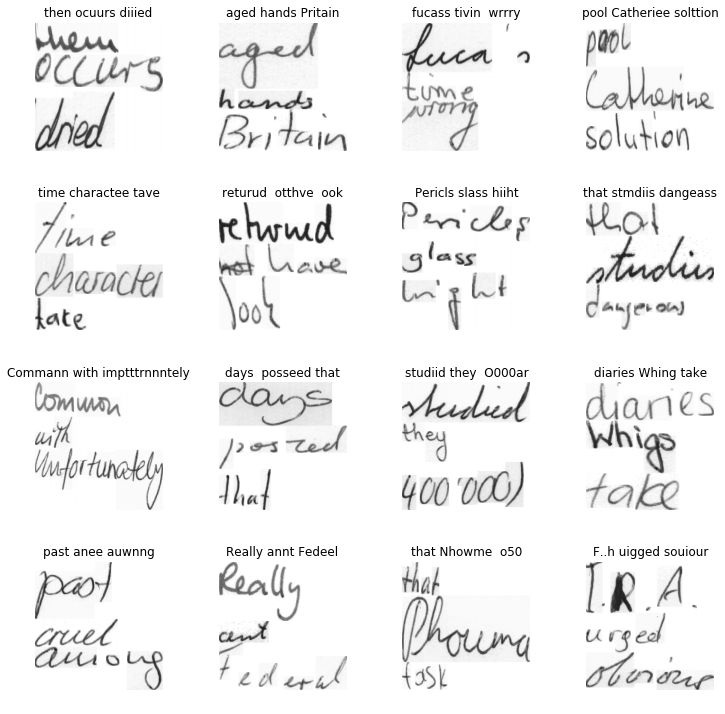

In [44]:
im = data.trn_ds.denorm(x)

fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(im[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

## Attention Visualization

In [45]:
attn = to_np(attns[:,:,0])  # first batch

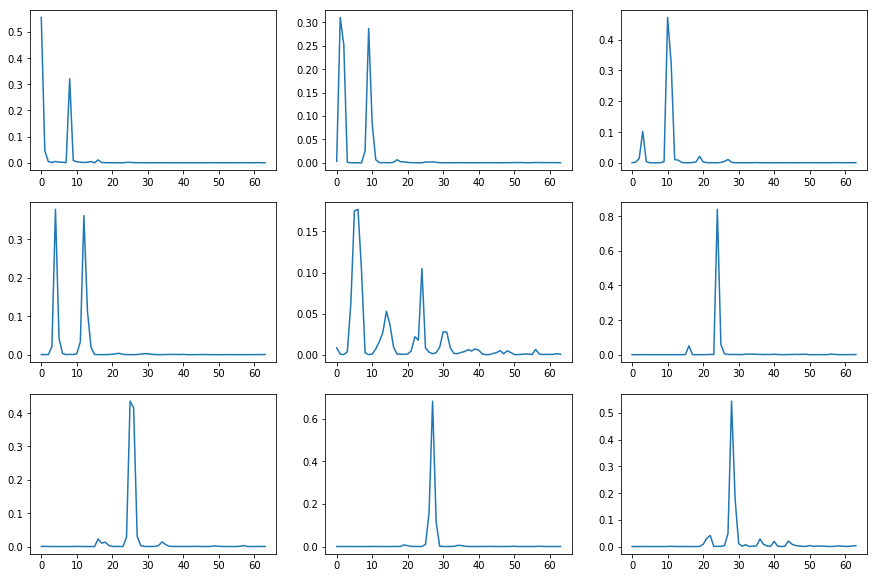

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i,ax in enumerate(axes.flat):
    ax.plot(attn[i])

# Show, Attend, Tell

In [13]:
class Encoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        
        net = f(True)
        modules = list(net.children())[:-3]    #(8,8,256)
        self.base = nn.Sequential(*modules)

        #mlp
        self.drop = nn.Dropout(0.3)
        self.linear1 = nn.Linear(256, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)    
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [64]:
class LuongDecoder(nn.Module):
    def __init__(self, embed_size, num_layers):
        super().__init__()
        
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        
        # Attention Layers
#         self.attn_1 = nn.Linear(embed_size, embed_size)
#         self.attn_2 = nn.Linear(embed_size, embed_size)
#         self.attn_v = rand_p(embed_size)
          
        # Luong attention
        self.attn_l1 = nn.Linear(embed_size*2, embed_size)
        self.attn_v = nn.Parameter(torch.FloatTensor(embed_size))
        self.attn_l2 = nn.Linear(embed_size*2, embed_size)

    def forward(self, prev_embed, hidden, feats):
        # this is called once for each timestep
        
#         w1e = self.attn_1(feats)                    # ([64, 30, 256])
#         w2h = self.attn_2(hidden)                   # ([30, 256])
#         u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
#         a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
#         context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
#         _, h = self.dec_rnn(context.unsqueeze(0), hidden.unsqueeze(0))  # replace w/ linear layers
#         return h.squeeze(0), context, a
    
            
        # Luong attention
        # Forward through unidirectional GRU
        rnn_output, hidden = self.dec_rnn(prev_embed.unsqueeze(0), hidden.unsqueeze(0))
        
        #expand hidden dims(0) to match feats
        concat = torch.cat((hidden.expand(feats.size(0), -1, -1), feats), 2)     #([64,30,512])
        energy = torch.tanh(self.attn_l1(concat))                                #([64,30,256])
        attn_energies = torch.sum(self.attn_v * energy, dim=2)                   #([64,30])
        attn_weights = torch.softmax(attn_energies.t(), dim=1).unsqueeze(1)      #([30, 1, 64])
    
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(feats.transpose(0, 1))                        #([30, 1, 256])
        
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        concat_input = torch.cat((rnn_output.squeeze(0), context.squeeze(1)), 1) #([30, 512])
        concat_output = torch.tanh(self.attn_l2(concat_input))                   #([30, 256])

        return hidden.squeeze(0), concat_output, attn_weights

In [14]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [ ]:
class GRU2d(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        
        self.reset = nn.Linear(embed_size*2, embed_size)
        self.update = nn.Linear(embed_size*2, embed_size)
        self.gate_i = nn.Linear(embed_size, embed_size)
        self.gate_h = nn.Linear(embed_size, embed_size)
        
    def forward(self, inputs, hidden):
        u_gate = torch.sigmoid(self.update(torch.concat([inputs,hidden], 1)))
        r_gate = torch.sigmoid(self.reset(torch.concat([inputs,hidden], 1)))
        g_gate = torch.tanh(self.gate(torch.concat([inputs, r_gate*hidden], 1)))
        out = (1-u_gate)*hidden + u_gate*g_gate

In [32]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers):
        super().__init__()
        
        self.dec_rnn = nn.GRU(embed_size, embed_size, num_layers)
        
        # Attention Layers
        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.attn_3 = nn.Linear(embed_size*2, embed_size)
        self.attn_v = rand_p(embed_size)
               
    def forward(self, prev_embed, hidden, feats):
        # this is called once for each timestep
        
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention

#         wgt_enc = self.attn_3(torch.cat([prev_embed, context], 1))    # maybe losing info here??
        wgt_enc = context   # ignore prev_embed

        _, h = self.dec_rnn(wgt_enc.unsqueeze(0), hidden.unsqueeze(0))  # replace w/ linear layers
        
        return h.squeeze(0), context, a

In [16]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
#         self.w3 = nn.Linear(embed_size, vocab_size) #v1
        self.w3 = nn.Linear(embed_size*3, vocab_size) #v2
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)    # using previous embedding instead of previous input vector
        b = self.w1(hidden)
        c = self.w2(context)
        
#         out = self.w3(a+b+c) #v1
        out = self.w3(torch.cat([a,b,c], 1)) #v2
        return out

In [65]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, dropout=0.1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.encoder = Encoder(hidden_size)
#         self.decoder = Decoder(hidden_size, n_layers)
        self.decoder = LuongDecoder(hidden_size, n_layers)
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.output  = DeepOutputLayer(hidden_size, vocab_size)

        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, enc_h = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        hidden = enc_h
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            hidden, context, a = self.decoder(prev, hidden, feats)
            attns.append(a)
            out = self.output(prev, hidden, context)
            res.append(out)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [66]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 40, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss

 31%|███       | 87/284 [00:31<01:10,  2.78it/s, loss=405]

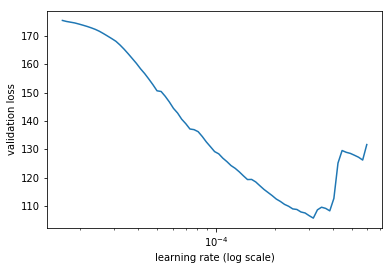

In [67]:
learn.lr_find()
learn.sched.plot(n_skip_end=1)

In [68]:
lr=1e-3  #10000 dataset
learn.fit(lr, 1, cycle_len=1)

#10000, bs:30, sz: 128, num_layers: 1, lr:1e-3, em_sz: 256

# linear (not deep) output                  65.85
# "", attn w/out prev_emb                   60.82
# deep output - mlp                         nan
# deep output - addition                    67.39
# deep output - concat                      67.95
# "", attn w/out prev_emb                   66.20
# rnn->linears in decoder
# Luong attn decoder                        66.36

epoch      trn_loss   val_loss                                  
    0      121.70329  66.355498 


[66.355498046875]

In [149]:
lr=7e-4
learn.fit(lr, 1, cycle_len=1)

#1000, bs:30, sz: 128, num_layers: 1, lr:7e-4, em_sz: 256
# output addition                           79.87
# output concat                             76.77
# output mlp                                84.69
# linear (not deep) output                  74.09
# "", attn w/out prev_emb                   80.44

epoch      trn_loss   val_loss                           
    0      115.494659 80.442029 


[80.44202880859375]

In [69]:
learn.fit(lr, 3, cycle_len=1)

# 1000
# output addition
#     0      109.464699 80.655455 
#     1      117.790291 77.301024                          
#     2      101.501918 74.087868     10000:   63.757736  64.09727

# output concat
#     0      121.130733 79.116313 
#     1      106.830037 74.848442                          
#     2      99.965209  72.469034     10000:   63.361161  63.640719

# "", attn w/out prev_emb             10000:   62.51545   62.879461

# output mlp
#     0      3067.757661 80.598882 
#     1      1163.911604 73.455244                              
#     2      645.503707  72.828899

# linear (not deep) output
#     0      90.413353  71.51237  
#     1      95.126303  69.32448                            
#     2      88.002041  69.246541      10000:   63.345379  62.93458    

# "", attn w/out prev_emb
#     0      79.627232  70.395955 
#     1      128.456384 71.310184                          
#     2      106.108512 70.501785      10000:   64.519318  64.044387

# Luong Attention decoder              10000:   64.774495  64.690419

epoch      trn_loss   val_loss                              
    0      66.395248  65.697661 
    1      66.969275  65.257354                             
    2      64.774495  64.690419                             


[64.69041870117188]

In [70]:
# lr = 1e-4
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))

#10000
# linear (not deep) output      55.973263  56.410798  'showattendtell_1inear' (definitely working!!)
# "", attn w/out prev_emb       61.039778  61.661973
# deep output concat            43.561881  44.510029  'showattendtell_deepconcat'
# "", attn w/out prev_emb       39.949578  42.628508  'showattendtell_deepconcat_noprev'
# Luong Attention decoder       60.528437  63.590961

epoch      trn_loss   val_loss                              
    0      64.191453  65.133162 
    1      63.578995  63.277793                             
    2      63.035224  62.75052                              
    3      62.679289  63.229116                             
    4      61.989141  62.802339                             
    5      61.643481  63.762018                             
    6      61.175512  63.902859                             
    7      60.897011  62.293725                             
    8      60.144747  62.587843                             
    9      60.528437  63.590961                             


[63.59096099853516]

In [38]:
learn.save('showattendtell_deepconcat_noprev')

In [39]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))

epoch      trn_loss   val_loss                              
    0      37.301484  41.277014 
    1      35.977864  39.959879                             
    2      33.303359  40.19116                              
    3      31.637834  38.435231                             
    4      30.310499  37.784272                             
    5      28.384277  36.97356                              
    6      26.910628  36.660546                             
    7      25.893854  36.205699                             
    8      25.110505  35.516296                             
    9      23.402106  35.502501                             



[35.50250106811524]

In [40]:
learn.save('showattendtell_deepconcat_noprev_24epochs')

### Example

https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        vggnet = torchvision.models.vgg19(pretrained=True)
        modules = list(vggnet.children())[:-1]
        self.vggnet = nn.Sequential(*modules)
        self.linear = nn.Linear(vggnet.classifier[6].in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0.0, 0.2)
        self.linear.bias.data.fill_(0)

    def forward(self, images):
        features = self.vggnet(images)
        features = Variable(features.data)
        print (features)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class AttnDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self):
        return cuda_variable(torch.zeros(self.num_layers, 1, self.hidden_size))

    def forward(self, captions, last_hidden, encoder_hiddens, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((last_hidden.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        rnn_output = self.linear(hiddens[0])
        print (rnn_output)

        attn_weights = self._get_att_weight(rnn_output.squeeze(0), encoder_hiddens)
        context = attn_weights.bmm(encoder_hiddens.transpose(0,1))

        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = self.out(torch.cat((rnn_output, context), 1))

        return output

    def _get_att_weight(self, hidden, encoder_hiddens):
        seq_len = len(encoder_hiddens)

        # Create variable to store attention energies
        attn_scores = cuda_variable(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(seq_len):
            attn_scores[i] = self.get_att_score(hidden, encoder_hiddens[i])

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)


    def get_att_score(self, hidden, encoder_hidden):
        score = self.attn(encoder_hidden)
        return torch.dot(hidden.view(-1), score.view(-1))


def cuda_variable(tensor):
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

In [ ]:
def main(args):
    transform = transforms.Compose([
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224,
                              0.225))
    ])

    data_loader = get_loader(args.image_dir, args.caption_path, vocab, transform, 128,
                             shuffle=True, num_workers=2)

    encoder = EncoderCNN(256)
    decoder = AttnDecoderRNN(256, 512, len(vocab), 1)

    if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)

    total_step = len(data_loader)
    decoder_hidden = decoder.init_hidden()

    for epoch in range(5):
        for i, (images, captions, lengths) in enumerate(data_loader):

            images = cuda_variable(images, volatile=True)
            captions = cuda_variable(captions)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            decoder.zero_grad()
            encoder.zero_grad()
            features = encoder(images)

            outputs = decoder(captions, decoder_hidden, features, lengths)
            # outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

# Combo

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.max_seq_length = max_seq_length

        *self.attn = nn.Linear(hidden_size, hidden_size)
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        #return outputs

        *attn_weights = self.get_attn_weights(outputs.squeeze(0), features)
        *context = attn_weights.bmm(features.transpose(0,1))

        *result = self.out(torch.cat((outputs.squeeze(0), context.squeeze(1)), 1))
        *return result

    *def get_attn_weights(self, hidden, features):
        seq_len = len(features)

        # Create variable to store attention energies
        attn_scores = V(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(self.seq_len):
            score = self.attn(features)
            attn_scores[i] = torch.dot(hidden.view(-1), score.view(-1))

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)

    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# Image Captioning
https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = torchvision.models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # without the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(args):
    
    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([ 
        transforms.RandomCrop(args.crop_size),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Build data loader
    data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                             transform, 128, shuffle=True, num_workers=2) 

    # Build the models
    encoder = EncoderCNN(256).to(device)
    decoder = DecoderRNN(256, 512, len(vocab), 1).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)
    
    # Train the models
    total_step = len(data_loader)
    for epoch in range(5):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

def sample(args):
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(args.vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Build models
    encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(256, 512, len(vocab), 1)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # Load the trained model parameters
    encoder.load_state_dict(torch.load(args.encoder_path))
    decoder.load_state_dict(torch.load(args.decoder_path))

    # Prepare an image
    image = load_image(args.image, transform)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(args.image)
    plt.imshow(np.asarray(image))

# Transformer

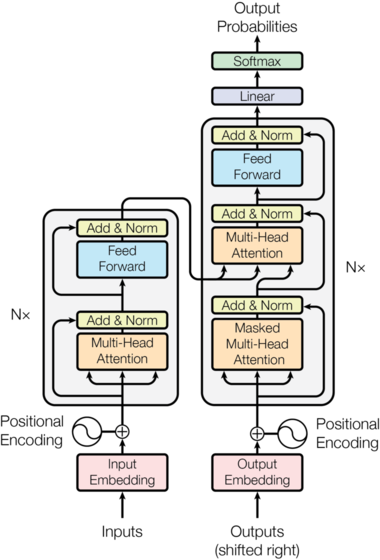

In [37]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [38]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [39]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
# same as batchnorm but on a layer level
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [40]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)
    
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

### Attention
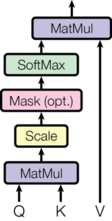

In [41]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [42]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [ ]:
# class PositionalEncoding(nn.Module):
#     "Implement the PE function."
#     def __init__(self, d_model, dropout, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)
        
#         # Compute the positional encodings once in log space.
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0.0, max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0.0, d_model, 2) * -(math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)
        
#     def forward(self, x):
#         x = x + Variable(self.pe[:, :x.size(1)], 
#                          requires_grad=False)
#         return self.dropout(x)

In [50]:
emb = Embeddings(256, len(itos))
emb(y.long()).shape

torch.Size([30, 30, 256])

In [60]:
class ImageProcessor(nn.Module):
    def __init__(self, d_model):
        super(ImageProcessor, self).__init__()
        self.d_model = d_model
        head = nn.Conv2d(256, self.d_model, 1)
        self.image_enc = ConvnetBuilder(f, 0, 0, 1, xtra_cut=1, custom_head=head)

    def forward(self, x):
        return self.image_enc(x) * math.sqrt(self.d_model)

In [43]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [58]:
def custom_transformer(tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    #position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        ImageProcessor(d_model),
        Embeddings(d_model, tgt_vocab),
        #nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        #nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [61]:
# head = nn.Conv2d(256, 512, 1)
# image_encoder = ConvnetBuilder(f, 0, 0, 1, xtra_cut=1, custom_head=head)

net = custom_transformer(len(itos))
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(net)), opt_fn=opt_fn)
learn.clip = 0.1
learn.crit = seq2seq_loss

In [62]:
learn.lr_find()
learn.sched.plot()

  0%|          | 0/29 [00:00<?, ?it/s]


TypeError: forward() missing 3 required positional arguments: 'tgt', 'src_mask', and 'tgt_mask'

In [ ]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))